   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 394s 17s/step - accuracy: 0.7548 - iou_score: 0.4065 - loss: 0.5266 - val_accuracy: 0.4668 - val_iou_score: 0.3130 - val_loss: 0.6938
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 373s 16s/step - accuracy: 0.9510 - iou_score: 0.6210 - loss: 0.2333 - val_accuracy: 0.6383 - val_iou_score: 0.3343 - val_loss: 0.6742
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 381s 16s/step - accuracy: 0.9718 - iou_score: 0.7190 - loss: 0.1562 - val_accuracy: 0.7443 - val_iou_score: 0.2721 - val_loss: 0.5722
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 343s 16s/step - accuracy: 0.9804 - iou_score: 0.7521 - loss: 0.1270 - val_accuracy: 0.6608 - val_iou_score: 0.1522 - val_loss: 0.6888
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 380s 16s/step - accuracy: 0.9857 - iou_score: 0.7895 - loss: 0.1042 - val_accuracy: 0.6607 - val_iou_score: 0.1120 - val_loss: 0.7696
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 385s 16s/step - accuracy: 0.9846 - iou_score: 0.7949 - loss: 0.0993 - val_accuracy: 0.6607 - val_iou_s

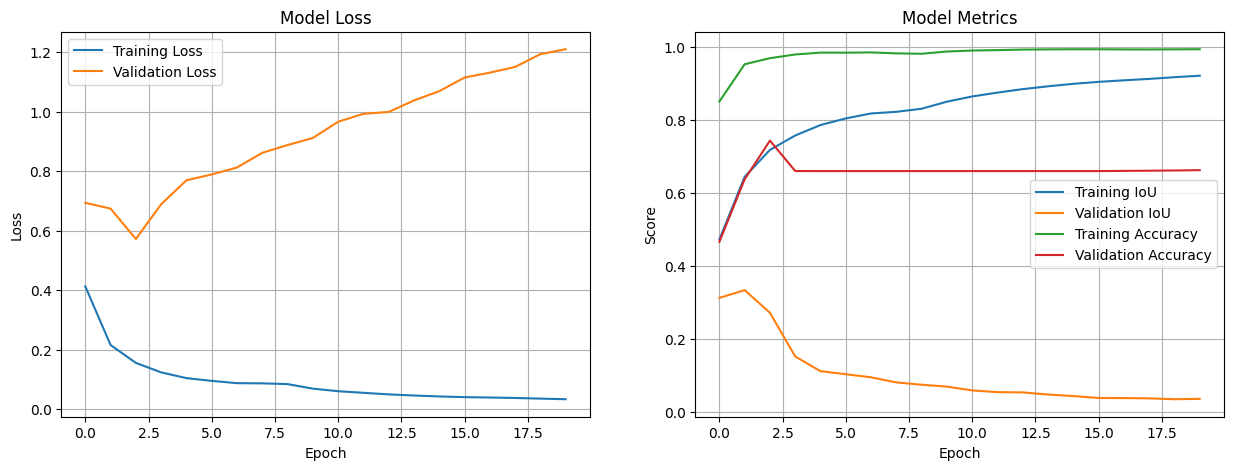

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.6949 - iou_score: 0.0439 - loss: 1.0957

Final Validation Loss: 1.2106
Final Validation IoU: 0.0362
Final Validation Pixel Accuracy: 0.6633


In [2]:
!pip install segmentation-models
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# FIX for the common 'AttributeError'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------------------------------------
# CRITICAL: PASTE YOUR CORRECT ZIP FILE PATH HERE
# Example: '/content/drive/MyDrive/my_folder/archive.zip'
# -----------------------------------------------------------
zip_path = '/content/drive/MyDrive/archive.zip'
unzip_path = '/content/unzipped_data'

# Unzip the file
!unzip -q "{zip_path}" -d "{unzip_path}"

# The path to the root of your unzipped dataset
DATASET_PATH = os.path.join(unzip_path, 'car-segmentation')

# Define image dimensions and number of classes
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
NUM_CLASSES = 1

# Get image and mask paths
image_dir = os.path.join(DATASET_PATH, 'images')
mask_dir = os.path.join(DATASET_PATH, 'masks')

all_image_ids = sorted(os.listdir(image_dir))
all_mask_ids = sorted(os.listdir(mask_dir))

train_ids, val_ids = train_test_split(all_image_ids, test_size=0.2, random_state=42)

# Data Generator class
class CarSegGenerator(Sequence):
    def __init__(self, image_ids, dataset_path, batch_size, target_size=(256, 256)):
        self.image_ids = image_ids
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for image_id in batch_ids:
            img_path = os.path.join(self.dataset_path, 'images', image_id)
            image = Image.open(img_path).convert('RGB').resize(self.target_size)
            image = np.array(image, dtype=np.float32) / 255.0
            batch_images.append(image)

            mask_id = image_id.replace('.jpg', '.png')
            mask_path = os.path.join(self.dataset_path, 'masks', mask_id)
            mask = Image.open(mask_path).convert('L').resize(self.target_size, Image.NEAREST)
            mask = np.array(mask, dtype=np.float32) / 255.0
            mask[mask > 0] = 1.0
            batch_masks.append(np.expand_dims(mask, axis=-1))

        return np.array(batch_images), np.array(batch_masks)

train_generator = CarSegGenerator(train_ids, DATASET_PATH, batch_size=8)
val_generator = CarSegGenerator(val_ids, DATASET_PATH, batch_size=8)

# Model Training
model = sm.Unet(
    'resnet50',
    encoder_weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=NUM_CLASSES,
    activation='sigmoid'
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sm.losses.binary_crossentropy,
    metrics=[sm.metrics.iou_score, 'accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

# Metrics and Visualization
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(history.history['iou_score'], label='Training IoU')
    ax2.plot(history.history['val_iou_score'], label='Validation IoU')
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Metrics'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Score'); ax2.legend(); ax2.grid(True)
    plt.show()

plot_metrics(history)

loss, iou, accuracy = model.evaluate(val_generator, verbose=1)
print(f"\nFinal Validation Loss: {loss:.4f}")
print(f"Final Validation IoU: {iou:.4f}")
print(f"Final Validation Pixel Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


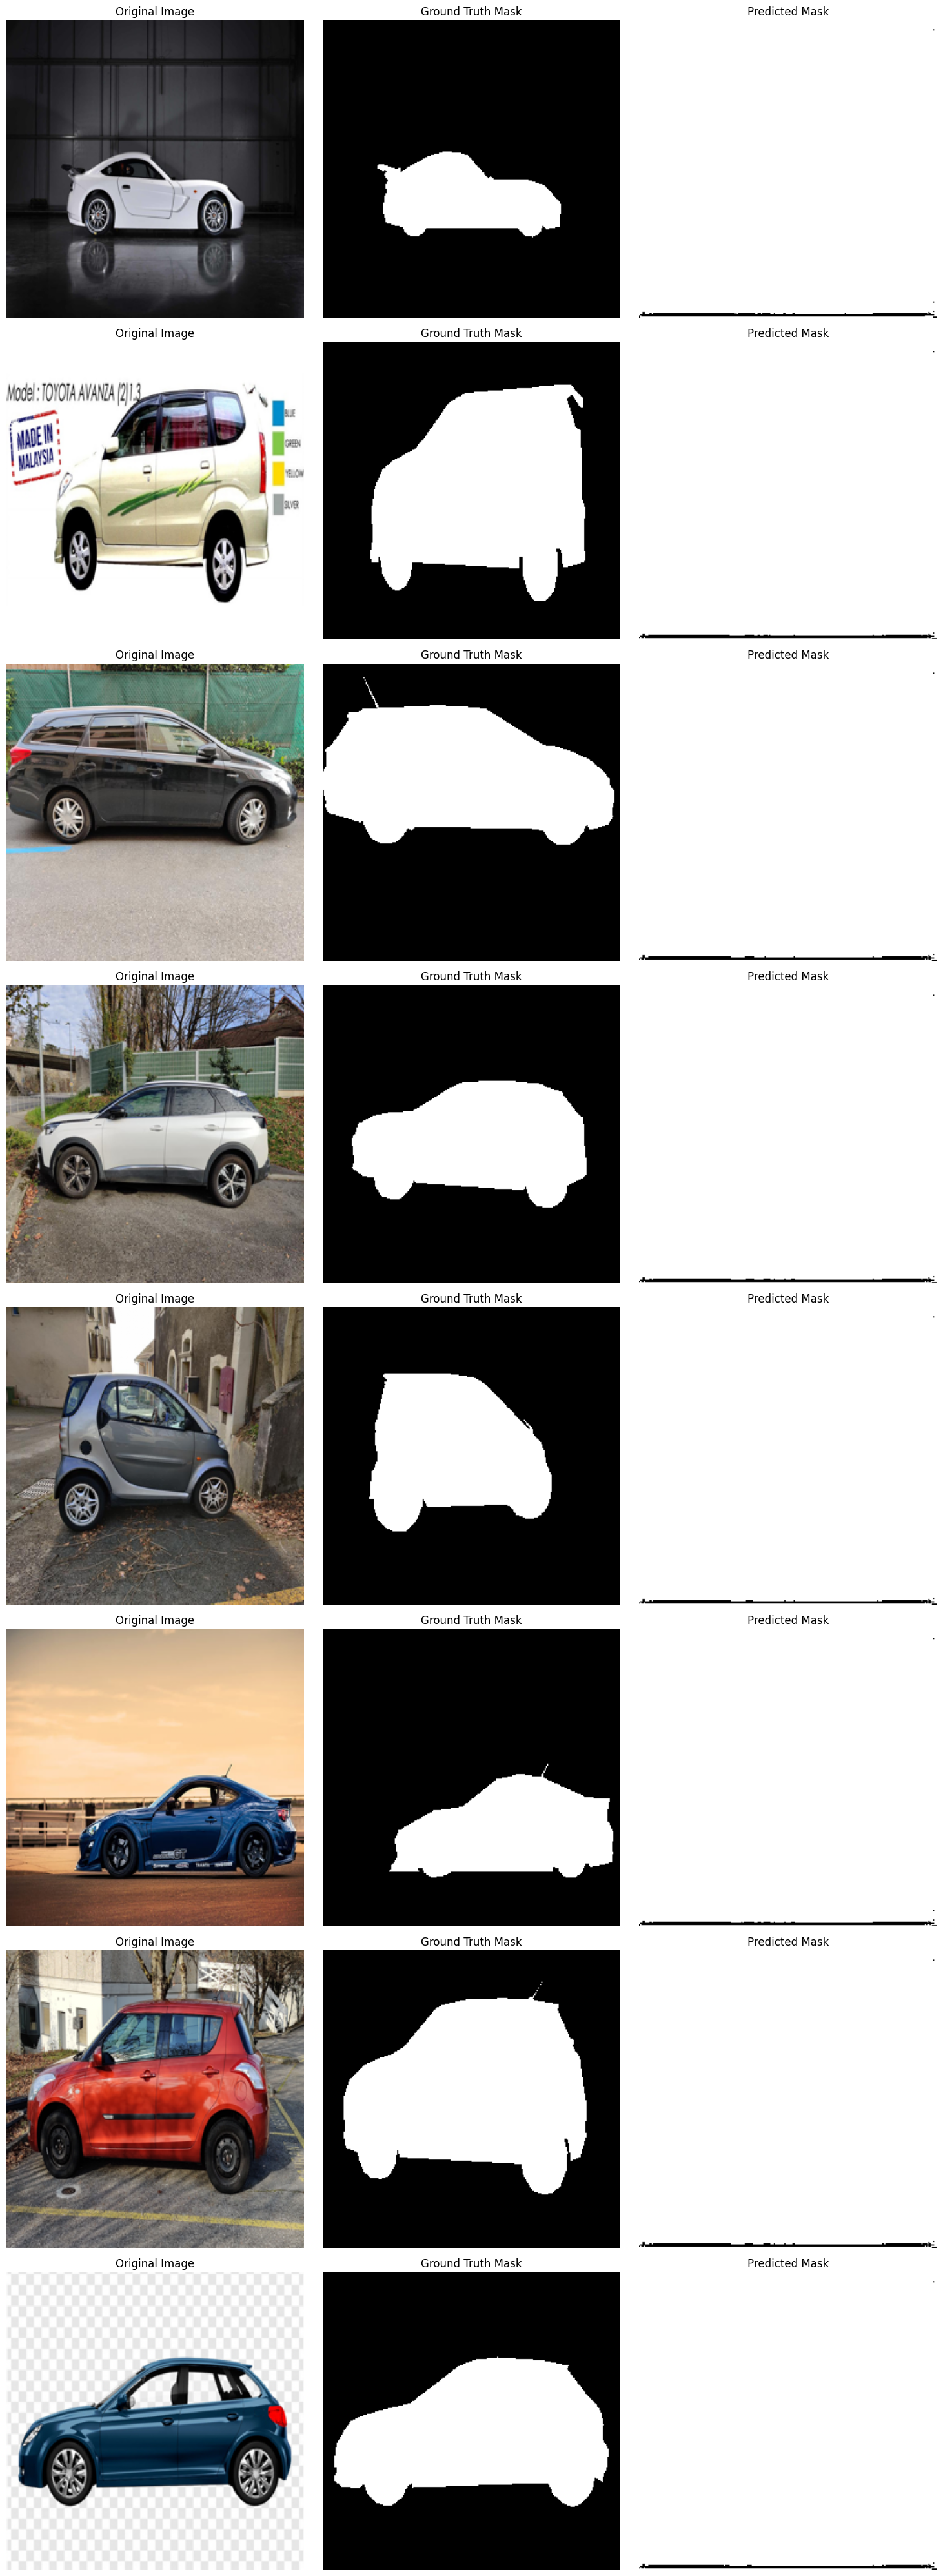

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def display_predictions(model, data_generator, num_samples=5):
    """
    Displays original images, ground truth masks, and predicted masks.
    This improved version handles both binary and multi-class segmentation.

    Args:
        model: The trained Keras/TensorFlow segmentation model.
        data_generator: A data generator for validation or test data.
        num_samples: The number of samples to display.
    """

    # Get a batch of images and masks from the generator
    images, true_masks = next(iter(data_generator))

    # Make predictions on the images
    predictions = model.predict(images[:num_samples])

    # Determine if the model is binary or multi-class based on output channels
    output_channels = predictions.shape[-1]

    # Handle multi-class vs. binary predictions
    if output_channels > 1:
        # For multi-class, use argmax to get the class with the highest probability
        predicted_masks = np.argmax(predictions, axis=-1).astype('float32')
        # Squeeze the true masks as well, if necessary
        if true_masks.shape[-1] > 1:
            true_masks_display = np.argmax(true_masks[:num_samples], axis=-1).astype('float32')
        else:
            true_masks_display = true_masks[:num_samples].squeeze(-1)
        cmap_mask = 'jet'  # Use a colorful colormap for multi-class
    else:
        # For binary, use a threshold (0.5) to get a black and white mask
        predicted_masks = (predictions > 0.5).astype('float32').squeeze(-1)
        true_masks_display = true_masks[:num_samples].squeeze(-1)
        cmap_mask = 'gray' # Use a grayscale colormap for binary

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks_display[i], cmap=cmap_mask)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i], cmap=cmap_mask)
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization function on a few samples from your validation set
display_predictions(model, val_generator, num_samples=8)